In [1]:
import numpy as np
import ot
import matplotlib.pyplot as plt
from tqdm import trange,tqdm
from sklearn.decomposition import PCA
import seaborn as sns

import gwb as gwb
from gwb import GM as gm
from scipy.stats import ortho_group, multivariate_normal
from scipy.linalg import sqrtm,inv

In [2]:
np.random.seed(2)

N = 4
n = 1000

means = np.zeros((N,2))
Ds = np.array([
    [[5,0],[0,0.5]],
    [[2,0],[0,0.5]],
    [[0.5,0],[0,0]],
    [[5,0],[0,0]]
    ])
Os = [ortho_group.rvs(dim=2) for _ in range(N)]
covs = [Os[i].T.dot(Ds[i]).dot(Os[i]) for i in range(N)]
points = [np.array([np.random.multivariate_normal(means[i],covs[i]) for _ in range(n)]) for i in range (N)]
gs = [points[i].dot(points[i].T) for i in range(N)]

In [3]:
gwbls = []
ns = [50,100,500,1000,2000]
for n in tqdm(ns):#,1000,1500]:
    gwbls_per_n = []
    for k in range(100):
        np.random.seed(k)
        
        #sample gauss, set gauges
        points = [np.array([np.random.multivariate_normal(means[i],covs[i]) for _ in range(n)]) for i in range (N)]
        gs = [points[i].dot(points[i].T) for i in range(N)]

        #create gm-spaces
        Xs = []
        for i in range(N):
            Xs.append(gm(mode="gauge_only",X = points[i],g=gs[i]))

        #one iteration of TB (two to compute loss)
        n_its_tb = 2
        method = "cg"
        cr = "NWCR"
        bary = 0
        init_Ps = None
        gwbl_prevs = []
        #times = [0]
        #st = time.time()
        for it in range(n_its_tb):
            bary_prev = bary
            idxs, meas, Ps, ref_idx = gwb.tb(bary_prev,Xs,method=method,cr=cr)
            bary = gwb.bary_from_tb(Xs,idxs,meas)
            gwbl_prev = gwb.gwb_loss(bary_prev,Xs,Ps)
            #times.append(time.time() - st)
        gwbls_per_n.append(gwbl_prev)
    gwbls.append(gwbls_per_n)
            

100%|█████████████████████████████████████████| 5/5 [3:40:07<00:00, 2641.51s/it]


In [4]:
def gw_gauss_ip(D1,D2):
    """
    Assumes Matrices are diagonal and sorted in decreasing order
    """
    return np.sqrt(np.sum(np.diag(D1)**2) + np.sum(np.diag(D2)**2) - (2 * np.sum(np.diag(D2.dot(D1)))))


true_igw = 0
for i in range(N):
    for j in range(i+1,N):
        true_igw += 0.25**2 * gw_gauss_ip(Ds[i],Ds[j])**2
        
print(true_igw)

3.8593750000000004


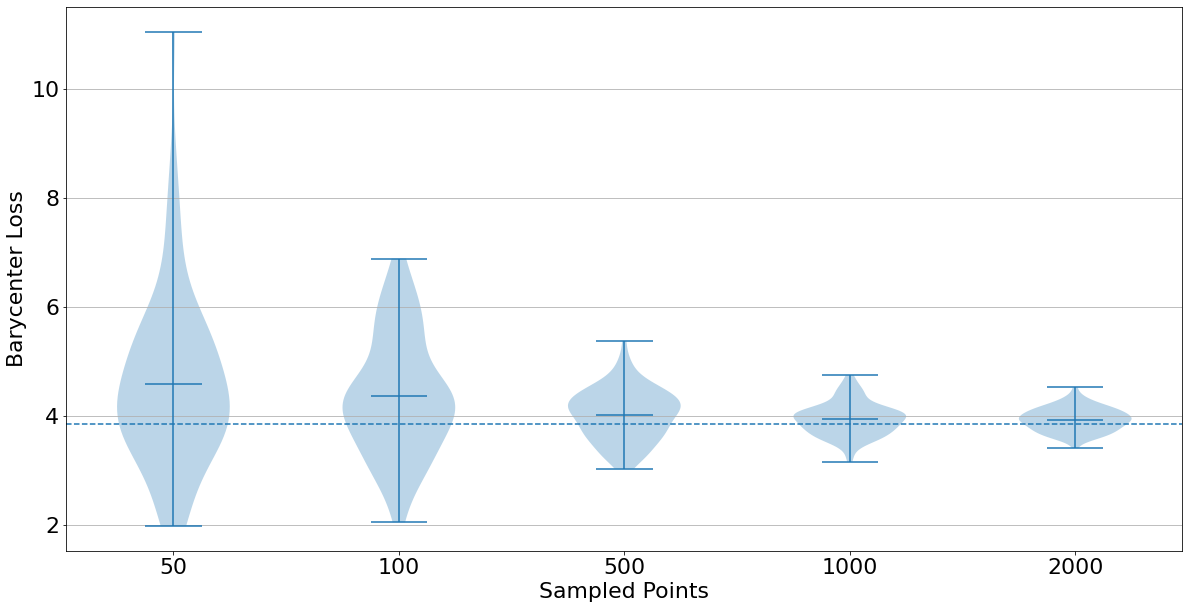

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plt.rcParams.update({'font.size': 40})
ax.axhline(y = true_igw, linestyle = '--',) 
#ax.text(5.5, true_igw, '$\mathrm{GWB}(\mathfrak{X}_1,\mathfrak{X}_2,\mathfrak{X}_3,\mathfrak{X}_4)$', ha='left', va='center')
ax.violinplot(gwbls,showmeans=True)
ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(len(gwbls))],
                  labels=ns)
ax.set_xlabel('Sampled Points')
ax.set_ylabel('Barycenter Loss')
plt.show()

In [6]:
colours = np.array(sns.color_palette())[1:5]

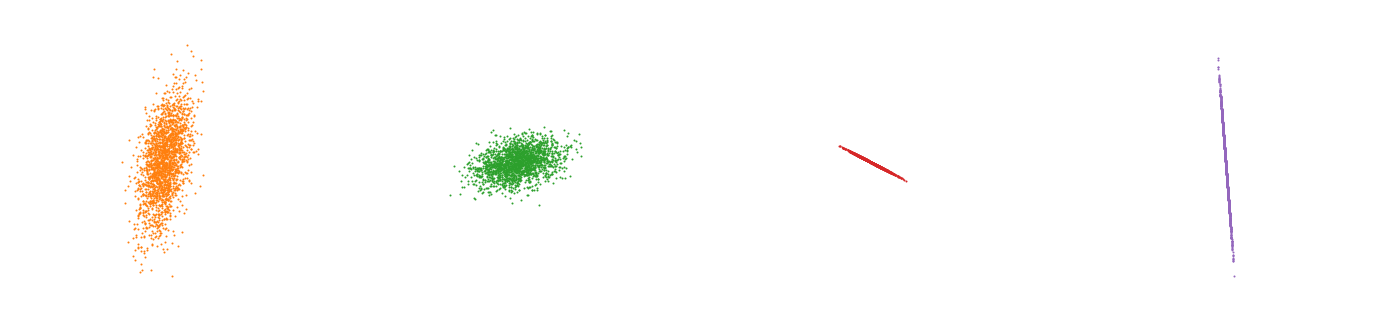

In [7]:
fig, ax = plt.subplots(1,N,figsize=(20,5))
plt.setp(ax, xlim=(-10, 10), ylim=(-10,10))
for x in ax:
    x.set_aspect(1.0)
    x.axis("off")
for i in range(N):
    ax[i].scatter(points[i][:,0],points[i][:,1],s=1,color = colours[i])
    
plt.tight_layout()
plt.show()

In [8]:
n_grid = 5
w = np.linspace(0, 1, n_grid)
ws = np.stack([
    (1-w[:, None])*(1-w[None, :]),
    (1-w[:, None])*w[None, :],
    w[:, None]*(1-w[None, :]),
    w[:, None]*w[None, :]
], axis=0).transpose((1, 2, 0)).reshape(-1, 4)

In [9]:
bary_embs_2d = np.zeros((n_grid,n_grid),dtype=object)
bary_cols = np.zeros((n_grid,n_grid,3))
for idx,w in enumerate(ws):
    i = idx // n_grid
    j = idx % n_grid
    bary_emb = gwb.create_surface_embedding(Xs,idxs,meas,ws=np.sqrt(w))
    pca = PCA(n_components=2)
    bary_emb_2d = pca.fit_transform(bary_emb)#,**{'weights': [[b]*6 for b in meas]})
    pca_s = gwb.pca_score(pca,bary_emb,meas)
    
    bary_cols[i,j] = w.dot(colours)
    bary_embs_2d[i,j] = bary_emb_2d

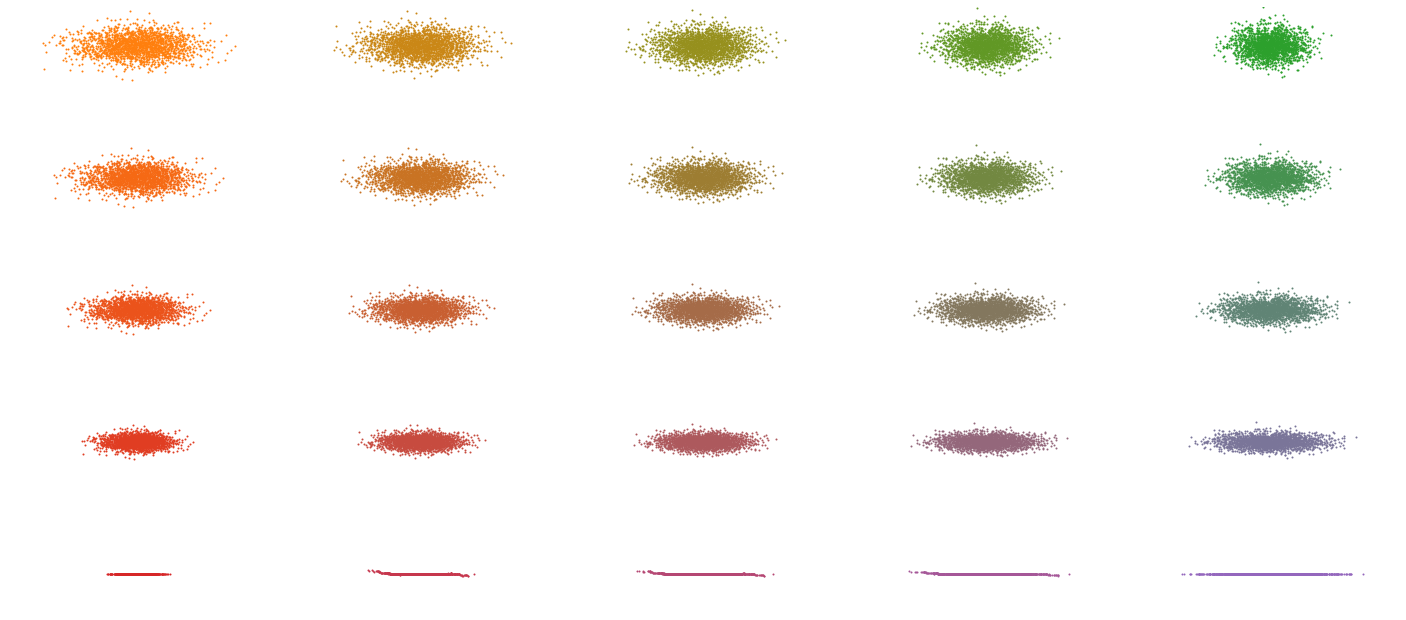

In [10]:
fig,ax = plt.subplots(n_grid,n_grid,figsize=(20,10))
plt.setp(ax, xlim=(-10, 10), ylim=(-3,3))

for i in range(n_grid):
    for j in range(n_grid):
        emb_2d = bary_embs_2d[i,j]
        ax[i,j].scatter(emb_2d[:,0],emb_2d[:,1],s=1,color=bary_cols[i,j])
        ax[i,j].set_aspect(1.0)
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()